In [1]:
!pip install PyPDF2
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 73.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.5/268.5 kB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 114.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.0 MB/s eta 0:00:00


In [2]:
pdf_path = '/content/NL_June2023.pdf'

In [3]:
import PyPDF2
import re
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
nltk.download('punkt')
nltk.download('stopwords')

def remove_string(content, string_to_remove):

    content = re.sub(string_to_remove, '', content)
    return content.strip()

def extract_pdf_content(pdf_path, start_page, end_page):
    content_array = []
    with open(pdf_path, 'rb') as file:
        reader = PyPDF2.PdfReader(file)
        num_pages = len(reader.pages)

        if start_page < 1 or end_page > num_pages:
            print("Invalid page range.")
            return content_array

        for page_number in range(start_page - 1, end_page):
            page = reader.pages[page_number]
            content = page.extract_text()

            content = remove_string(content, r'\nJUNE 2023\nDRDO NEWSLETTERCOVER STORY\n')
            content_array.append(content)
    return content_array

start_page = 4
end_page = 24

page_content_array = extract_pdf_content(pdf_path, start_page, end_page)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
def preprocess_text(text):
    try:
        text = text.replace('\n', ' ')
        text = re.sub(r'\s+', ' ', text)
        text = text.strip()
        # text = text.encode('latin-1', 'ignore').decode('latin-1')
    except UnicodeEncodeError:
        print("Warning: Skipping word due to encoding issue")

    return text
preprocessed_array = [preprocess_text(text) for text in page_content_array]

In [5]:
from transformers import BartTokenizer, BartForConditionalGeneration

def summarize_text(text):

    model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn")
    tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")

    inputs = tokenizer.encode(text, return_tensors="pt", max_length=1024, truncation=True)

    summary_ids = model.generate(inputs, num_beams=4, max_length=400, early_stopping=True)
    summary = tokenizer.decode(summary_ids.squeeze(), skip_special_tokens=True)

    return summary

In [6]:
text = preprocessed_array[1]
summary = summarize_text(text)

print("Summary:")
print(summary)


Summary:
National Technology Day 2023 was celebrated at the Armament Research & Development Establishment (ARDE), Pune, on 11 May 2023. The event was graced by Prof. Padmanav Acharya, NITIE, Mumbai as the Chief Guest. Besides, celebration at DRDO HQrs, following laboratories also celebrated NTD 2023 at their respective places: ACEM, Nasik Advanced Centre for Energetic Materials (ACEM), Nasik. ASL, Hyderabad Advanced Systems Laboratory (ASL), Hyderabad. CABS, Bengaluru Centre for Air Borne Systems (CABS), Bengaluru.


In [7]:
len(summary)

511

In [20]:
from transformers import pipeline
models = [
    {
        "model": "distilbert-base-cased-distilled-squad",
    },
    {
        "model": "bert-large-uncased-whole-word-masking-finetuned-squad",
    },
    {
        "model": "google/electra-base-discriminator",
    },

]

model_pipelines = []

for model_info in models:
    model = model_info["model"]
    qa_pipeline = pipeline(
        "question-answering",
        model=model,
    )
    model_pipelines.append(qa_pipeline)

context = " ".join(preprocessed_array)

question = "MOU was signed by whom?"
answers = []
for qa_pipeline in model_pipelines:
    result = qa_pipeline(question=question, context=context)
    answers.append(result["answer"])

aggregated_answer = max(set(answers), key=answers.count)

print("Aggregated Answer:")
print(aggregated_answer)


Some weights of the model checkpoint at google/electra-base-discriminator were not used when initializing ElectraForQuestionAnswering: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing ElectraForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForQuestionAnswering were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['qa_outputs.weight', 'qa_outputs.

Aggregated Answer:
Dr Samir V Kamat


In [8]:
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
additional_stop_words = ["director", "dr", "shri", "may", "june", "sc","april"]
stop_words.update(additional_stop_words)

def preprocess_text_word(text):

    text = text.lower()
    text = text.replace('\n', ' ')
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    text = text.lower()
    tokens = nltk.word_tokenize(text)

    tokens = [word for word in tokens if word not in stop_words]
    text = ' '.join(tokens)

    return text
preprocessed_array_word = [preprocess_text_word(text) for text in page_content_array]
# preprocessed_array_word[0]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


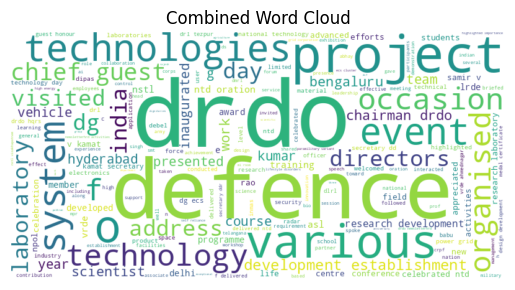

In [9]:
combined_text = ' '.join(preprocessed_array_word)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Combined Word Cloud')

plt.show()

In [10]:
import spacy
nlp = spacy.load('en_core_web_sm')

def perform_ner(text):
    doc = nlp(text)

    named_entities = []
    for entity in doc.ents:
        named_entities.append((entity.text, entity.label_))

    return named_entities

ner_results = []
for text in preprocessed_array:
    entities = perform_ner(text)
    ner_results.append(entities)

output_file = "ner_results.txt"
with open(output_file, 'w') as file:
    for i, entities in enumerate(ner_results):
        file.write(f"Named Entities in preprocessed_array[{i}]:\n")
        for entity in entities:
            file.write(f"{entity[0]} - {entity[1]}\n")
        file.write("\n")

print(f"NER results saved to {output_file}")


NER results saved to ner_results.txt


In [13]:
!pip install fpdf2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.8/276.8 kB 18.9 MB/s eta 0:00:00


In [14]:
def preprocess_text(text):
    try:
        text = text.replace('\n', ' ')
        text = re.sub(r'\s+', ' ', text)
        text = text.strip()
        text = text.encode('latin-1', 'ignore').decode('latin-1')
    except UnicodeEncodeError:
        print("Warning: Skipping word due to encoding issue")

    return text
preprocessed_array = [preprocess_text(text) for text in page_content_array]

In [16]:
from fpdf import FPDF, FPDFException

In [21]:
class CustomPDF(FPDF):
    # def header(self):
    #     self.set_font("Arial", "B", 16)
    #     self.cell(0, 10, "Summary of Pages", ln=True)
    #     self.ln(10)

    def chapter_title(self, title):
        self.set_font("Arial", "B", 14)
        self.cell(0, 10, title, ln=True)
        self.ln(10)

    def chapter_body(self, content):
        self.set_font("Arial", size=12)
        self.multi_cell(0, 10, content)
        self.ln(10)

In [22]:

def create_summary_pdf(pdf_path, start_page, end_page):
    pdf = CustomPDF()

    try:

        pdf.add_page()
        for i, text in enumerate(preprocessed_array):
            summary = summarize_text(text)

            pdf.chapter_title(f"Summary of Page {i + start_page}")
            pdf.chapter_body(summary)

        pdf.output("summary.pdf")
    except FPDFException as e:
        print(f"An error occurred while generating the PDF: {e}")

In [23]:
pdf_path = '/content/NL_June2023.pdf'
start_page = 4
end_page = 24

create_summary_pdf(pdf_path, start_page, end_page)

/usr/local/lib/python3.10/dist-packages/fpdf/fpdf.py:1919: UserWarning: Substituting font arial by core font helvetica
  warnings.warn(
<ipython-input-21-7fd6bbc857ea>:9: DeprecationWarning: The parameter "ln" is deprecated. Instead of ln=True use new_x=XPos.LMARGIN, new_y=YPos.NEXT.
  self.cell(0, 10, title, ln=True)


In [24]:
!pip freeze > requirements.txt